In [22]:
import pandas as pd
import numpy as np
import sqlite3
import statsmodels.api as sm

from plotnine import *
from mizani.formatters import percent_format
from regtabletotext import prettify_result


In [23]:
## load data

fintech_research_sql = sqlite3.connect(database="../data/fintech_research.sqlite")

crsp_monthly = (pd.read_sql_query(
    sql="SELECT permno, month, ret_excess, mktcap_lag FROM crsp_monthly",
    con=fintech_research_sql,
    parse_dates={"month"})
)

factors_ff3_monthly = pd.read_sql_query(
  sql="SELECT month, mkt_excess FROM factors_ff3_monthly",
  con=fintech_research_sql,
  parse_dates={"month"}
)

beta = (pd.read_sql_query(
    sql="SELECT permno, month, beta_monthly FROM beta",
    con=fintech_research_sql,
    parse_dates={"month"})
)

In [24]:
## sort by lagged beta
beta_lag = (beta
  .assign(month=lambda x: x["month"]+pd.DateOffset(months=1))
  .get(["permno", "month", "beta_monthly"])
  .rename(columns={"beta_monthly": "beta_lag"})
  .dropna()
)

data_for_sorts = (crsp_monthly
  .merge(beta_lag, how="inner", on=["permno", "month"])
)


In [25]:
beta_portfolios = (data_for_sorts
  .groupby("month")
  .apply(lambda x: (x.assign(
      portfolio=pd.qcut(
        x["beta_lag"], q=[0, 0.5, 1], labels=["low", "high"]))
    )
  )
  .reset_index(drop=True)
  .groupby(["portfolio","month"])
  .apply(lambda x: np.average(x["ret_excess"], weights=x["mktcap_lag"]))
  .reset_index(name="ret")
)

/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipykernel_36513/3759358879.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipykernel_36513/3759358879.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipykernel_36513/3759358879.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded 

In [26]:
beta_longshort = (beta_portfolios
  .pivot_table(index="month", columns="portfolio", values="ret")
  .reset_index()
  .assign(long_short=lambda x: x["high"]-x["low"])
)

/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipykernel_36513/586789714.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


In [27]:
model_fit = (sm.OLS.from_formula(
    formula="long_short ~ 1",
    data=beta_longshort
  )
  .fit(cov_type="HAC", cov_kwds={"maxlags": 6})
)
prettify_result(model_fit)

OLS Model:
long_short ~ 1

Coefficients:
           Estimate  Std. Error  t-Statistic  p-Value
Intercept       0.0       0.001        0.209    0.834

Summary statistics:
- Number of observations: 575
- R-squared: 0.000, Adjusted R-squared: 0.000
- F-statistic not available



In [28]:
## sort n portfolios

def assign_portfolio(data, sorting_variable, n_portfolios):
    """Assign portfolios to a bin between breakpoints."""
    
    breakpoints = np.quantile(
      data[sorting_variable].dropna(), 
      np.linspace(0, 1, n_portfolios + 1), 
      method="linear"
    )
    
    assigned_portfolios = pd.cut(
      data[sorting_variable],
      bins=breakpoints,
      labels=range(1, breakpoints.size),
      include_lowest=True,
      right=False
    )
    
    return assigned_portfolios

In [29]:
beta_portfolios = (data_for_sorts
  .groupby("month")
  .apply(lambda x: x.assign(
      portfolio=assign_portfolio(x, "beta_lag", 10)
    )
  )
  .reset_index(drop=True)
  .groupby(["portfolio", "month"])
  .apply(lambda x: x.assign(
      ret=np.average(x["ret_excess"], weights=x["mktcap_lag"])
    )
  )
  .reset_index(drop=True)
  .merge(factors_ff3_monthly, how="left", on="month")
)

/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipykernel_36513/980624139.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipykernel_36513/980624139.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipykernel_36513/980624139.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from

In [30]:
beta_portfolios_summary = (beta_portfolios
  .groupby("portfolio")
  .apply(lambda x: x.assign(
      alpha=sm.OLS.from_formula(
          formula="ret ~ 1 + mkt_excess", 
          data=x
        ).fit().params[0],
      beta=sm.OLS.from_formula(
          formula="ret ~ 1 + mkt_excess", 
          data=x
        ).fit().params[1],
      ret=x["ret"].mean()
    ).tail(1)
  )
  .reset_index(drop=True)
  .get(["portfolio", "alpha", "beta", "ret"])
)

/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipykernel_36513/4286400953.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipykernel_36513/4286400953.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipykernel_36513/4286400953.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/cg/mzzfcskd2g16hq9zj4rdllw00000gn/T/ipyke

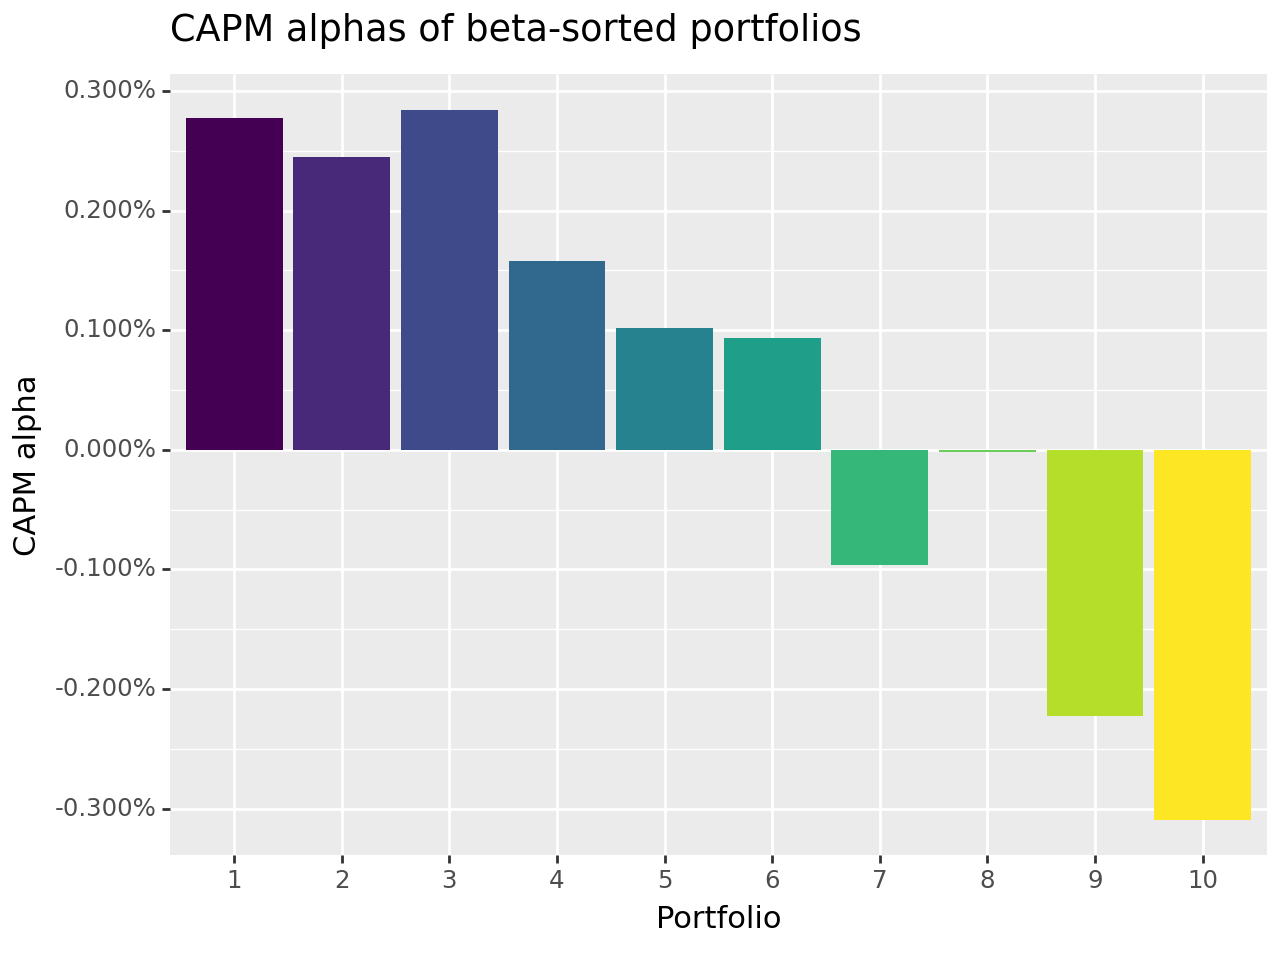

In [31]:
plot_beta_portfolios_summary = (
  ggplot(beta_portfolios_summary, 
         aes(x="portfolio", y="alpha", fill="portfolio")) +
  geom_bar(stat="identity") +
  labs(x="Portfolio", y="CAPM alpha", fill="Portfolio",
       title="CAPM alphas of beta-sorted portfolios") +
  scale_y_continuous(labels=percent_format()) +
  theme(legend_position="none")
)
plot_beta_portfolios_summary.draw()
